In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import astropy.io.fits as fits
import os
import glob
import natsort

#fitting the emission lines
from astropy.modeling import models, fitting
from astropy import constants as const
from astropy import units as u
import pandas as pd
from astropy.convolution import convolve, Box1DKernel
from scipy.signal import find_peaks
from astropy.table import Table, Column, QTable
from astropy.io import fits

#Lomb-Scargle Periodograms
from astropy.timeseries import LombScargle as LS

#fitting the absorption lines
from specutils.spectra import Spectrum1D
from specutils.fitting import fit_lines
import heapq
import math

In [9]:
def fitting_absorption_lines(wavelength_range, sp_csv, sp_fits, detections):
    ################################################################
    #### CONSTANTS
    ################################################################
    halpha = ((656.28 * u.nm).to(u.Angstrom)).value
    c = ((const.c).to(u.km/u.s)).value

    ################################################################
    #### INITIALIZING BLANK ARRAYS
    ################################################################
    dv_a = np.zeros(np.shape(sp_csv)[0])
    dv_e = np.zeros(np.shape(sp_csv)[0])
    time = np.zeros(np.shape(sp_csv)[0])
    file_path = np.zeros(np.shape(sp_csv)[0], dtype = str)
    fit_error = np.zeros(np.shape(sp_csv)[0])
    
    for i, val in enumerate(detections == "Yes"):
        ################################################################
        #### GETTING DATA
        ################################################################
        s_fits = sp_fits[i]
        hdulist = fits.open(s_fits)
        hdu = hdulist[0]
        MJD_OBS, EXPTIME = hdu.header["MJD-OBS"], hdu.header["EXPTIME"]
        time[i] = ((MJD_OBS * u.d) + (((EXPTIME/2)*u.s).to(u.d))).value

        s = sp_csv[i]
        file_path = (s.split(vispath,1)[1])
        w, f, e = np.loadtxt(s, unpack=True, delimiter=',')
        
        ################################################################
        #### NORMALIZING AND SMOOTHING FLUX & ERROR
        ################################################################
        min_range, max_range = wavelength_range[0], wavelength_range[1]
        fitter = fitting.LinearLSQFitter()
        n_init = models.Polynomial1D(1)
        range_mask = (w > min_range) & (w < max_range)
        w, f, e = w[range_mask], f[range_mask], e[range_mask]
        
        cont_mask = (w > 6400)  & (w < 6500) | (w > 6690) & (w < 6700 )
        w_cont, f_cont = w[cont_mask], f[cont_mask]
        n_fit = fitter(n_init, w_cont, f_cont)
        f = f / n_fit(w)
        f = convolve(f, Box1DKernel(10))
        
        smoothed_err = e / n_fit(w)
        smoothed_err = convolve(smoothed_err, Box1DKernel(10))
        e = smoothed_err / np.sqrt(10)

        ################################################################
        #### FINDING ABSORPTION AMPLITUDE & MEAN FOR MODEL INPUT
        ################################################################
        mask = (w > 6555) & (w < 6573)
        w_masked, f_masked = w[mask], f[mask]
        a_loc = (np.diff(np.sign(np.diff(f_masked))) > 0).nonzero()[0] + 1 
        absorption_mean = w_masked[a_loc][np.argmin(f_masked[a_loc])]
        absorption_amplitude = f_masked[a_loc][np.argmin(f_masked[a_loc])]

        ################################################################
        #### TYING FUNCTION FOR FITS
        ################################################################
        def tied_function(model):
            mean = model.mean_1.value
            return mean
        tied_parameters = {'mean_0': tied_function, 'mean_2': tied_function}

        ################################################################
        #### IF THERE ARE EMISSION LINES
        ################################################################
        if val == True:
            peak_loc = (np.diff(np.sign(np.diff(f_masked))) < 0).nonzero()[0] + 1 
            emission_mean = w_masked[peak_loc][np.argmax(f_masked[peak_loc])]
            emission_amplitude = f_masked[peak_loc][np.argmax(f_masked[peak_loc])]
            
            ################################################################
            #### MAKING THE MODEL
            ################################################################
            g1 = models.Gaussian1D(-absorption_amplitude, absorption_mean,0.5) #narrowest portion 
            g2 = models.Gaussian1D(-0.3, absorption_mean,5) #broader portion 
            g3 = models.Gaussian1D(-0.2, absorption_mean,30) #widest portion 
            g4 = models.Gaussian1D(0.2, emission_mean, 0.7) #emission line
            model = g1 + g2 + g3 + g4 + models.Const1D(1)
            
            model.mean_0.tied = tied_function
            model.mean_2.tied = tied_function
            model.stddev_0.fixed = True
            model.stddev_1.fixed = True
            model.stddev_2.fixed = True
            model.stddev_3.fixed = True
            
            fit = fitting.LevMarLSQFitter()
            g = fit(model, w, f, maxiter=1000000, weights = 1/e)        
            ################################################################
            #### CHECKING THE EFFICACY OF THE FITS
            ################################################################
            plt.style.use("seaborn")
            plt.figure(num=None, figsize=(15, 9),facecolor='w', edgecolor='k')
            plt.title("From File Number: %i, Emission Detection: %s" % (i, val), weight = "bold", size = 20)
            plt.plot(w, f, color = "darkblue")
            plt.plot(w, g(w), c = "orchid", label = "FIT")
            plt.axvline(halpha, color = "tomato", label = "Rest Position")
            plt.axvline(g.mean_0.value, color = "black", label = "Measured Position")
            plt.legend(loc = "lower right", prop = {"size":20})
            plt.tick_params("both", labelsize = 15)
            plt.savefig("/Users/linaflorez/Desktop/UT_TAURUS/Plots/H_ALPHA_FITS/HAlpha_%i.pdf" % (i))
            plt.show()
            
            ################################################################
            #### CALCULATION DOPPLER VELOCITY
            ################################################################
            absorption_line_mean = g.mean_0.value
            emission_line_mean = g.mean_3.value

            shift_a = (absorption_line_mean - halpha)
            dv_a[i] = c * (shift_a / halpha)

            shift_e = (emission_line_mean - halpha)
            dv_e[i] = c * (shift_e / halpha)
        
        
        ################################################################
        #### IF THERE ARE NOOOOOOOOO EMISSION LINES
        ################################################################
        else:
            ################################################################
            #### MAKING THE MODEL
            ################################################################
            g1 = models.Gaussian1D(-absorption_amplitude, absorption_mean,0.5) #narrowest portion 
            g2 = models.Gaussian1D(-0.3, absorption_mean,5) #broader portion 
            g3 = models.Gaussian1D(-0.2, absorption_mean,30) #widest portion 
            model = g1 + g2 + g3 + models.Const1D(1)
            
            model.mean_0.tied = tied_function
            model.mean_2.tied = tied_function
            model.stddev_0.fixed = True
            model.stddev_1.fixed = True
            model.stddev_2.fixed = True
            
            fit = fitting.LevMarLSQFitter()
            g = fit(model, w, f, maxiter=1000000, weights = 1/e)
            
            ################################################################
            #### CHECKING THE EFFICACY OF THE FITS
            ################################################################
            plt.style.use("seaborn")
            plt.figure(num=None, figsize=(15, 9),facecolor='w', edgecolor='k')
            plt.title("From File Number: %i, Emission Detection: %s" % (i, val), weight = "bold", size = 20)
            plt.plot(w, f, color = "darkblue")
            plt.plot(w, g(w), c = "orchid", label = "FIT")
            plt.axvline(halpha, color = "tomato", label = "Rest Position")
            plt.axvline(g.mean_1.value, color = "black", label = "Measured Position")
            plt.legend(loc = "lower right", prop = {"size":20})
            plt.tick_params("both", labelsize = 15)
            plt.savefig("/Users/linaflorez/Desktop/UT_TAURUS/Plots/H_ALPHA_FITS/HAlpha_%i.pdf" % (i))

            plt.show()
            
            ################################################################
            #### CALCULATION DOPPLER VELOCITY
            ################################################################
            absorption_line_mean = g.mean_0.value
            shift = (absorption_line_mean - halpha)
            dv_a[i] = c * (shift / halpha)
            dv_e[i] = 0 

        ###############################################################
        ### DETERMINING THE FIT ERROR 
        ############################################################### 
        fit_info = fit.fit_info["param_cov"]
        print("FIT INFO:", np.shape(fit_info), detections[i])
        if fit_info is not None:
            fit_error[i] = (np.sqrt(np.diag(fit_info))[2:-1][0])**2 #variance
        if fit_info is None:
            fit_error[i] = 0
    
    

    fit_df = pd.DataFrame()
    fit_df["MJD"] = time
    fit_df["Absorption -- DV (km/s)"] = dv_a
    fit_df["Emission -- DV (km/s)"] = dv_e
    fit_df["Fit Error"] = fit_error
    fit_df["Detections (based on previous dv measurements)"] = detections
    fit_df["File Path"] = file_path
    t = Table.from_pandas(fit_df)
    csv_name = input("File name for the table?")
    making_table = t.write("/Users/linaflorez/Desktop/UT_TAURUS/CSV_FILES/%s" % (csv_name), format="ascii.csv", overwrite=True)

### NEW DATA

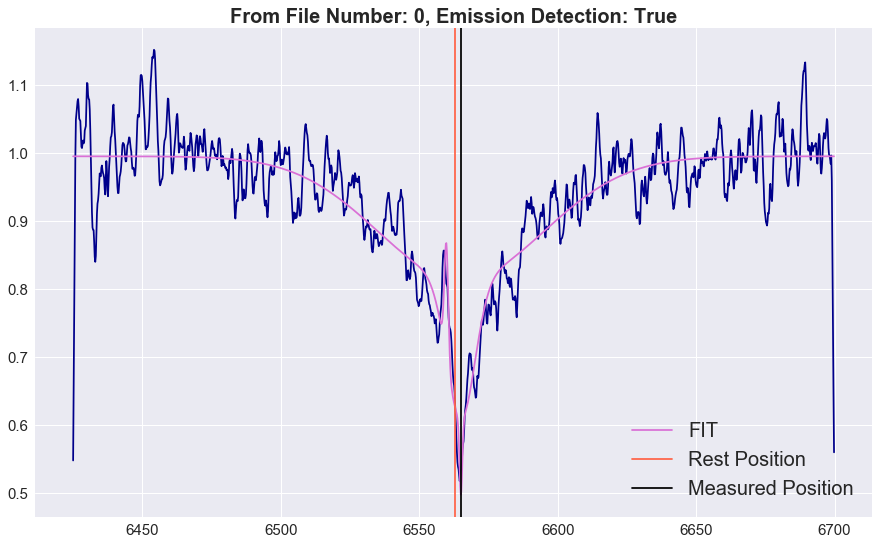

FIT INFO: (7, 7) Yes


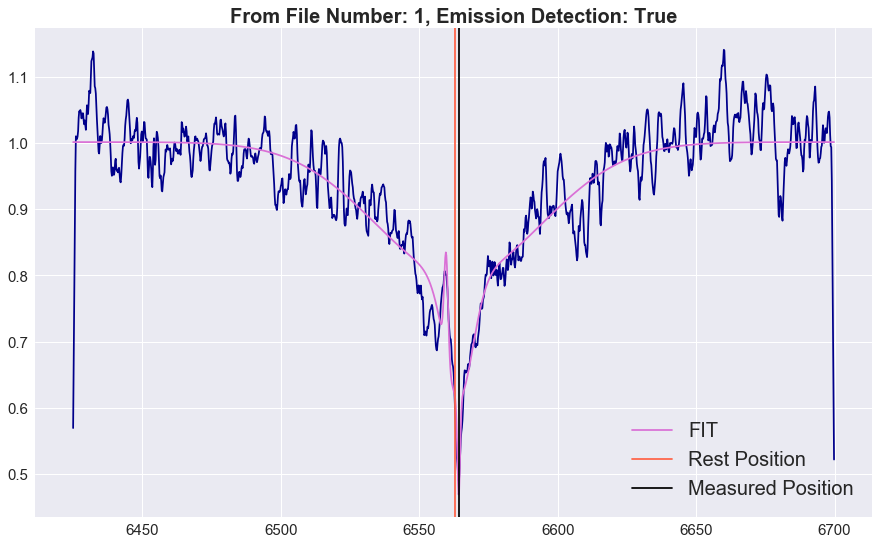

FIT INFO: (7, 7) Yes


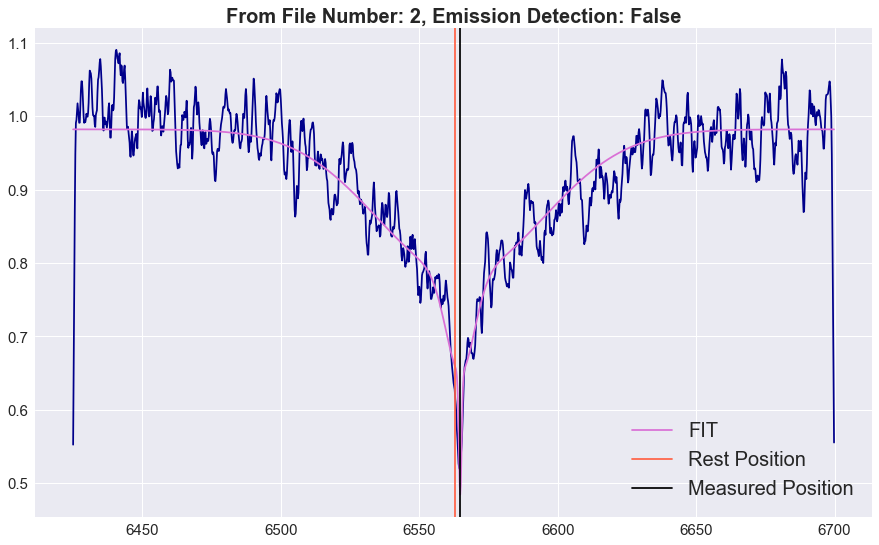

FIT INFO: (5, 5) No


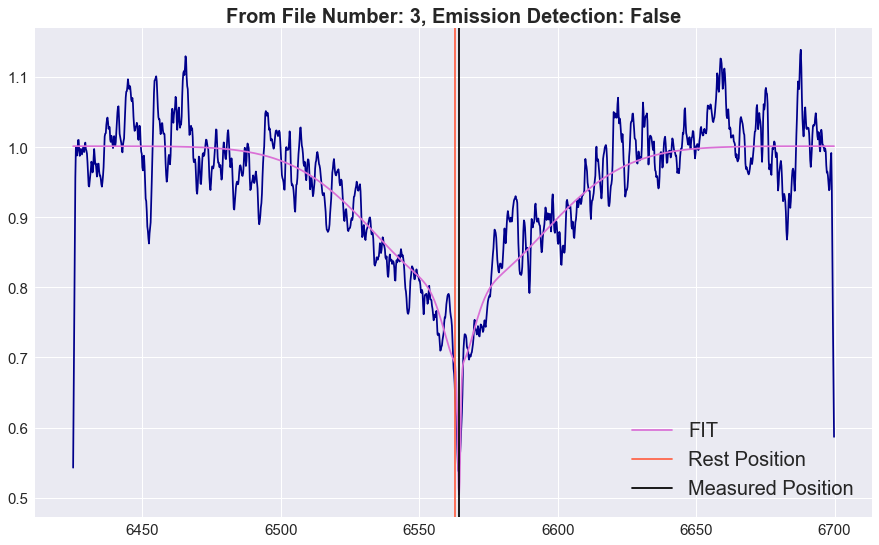

FIT INFO: (5, 5) No


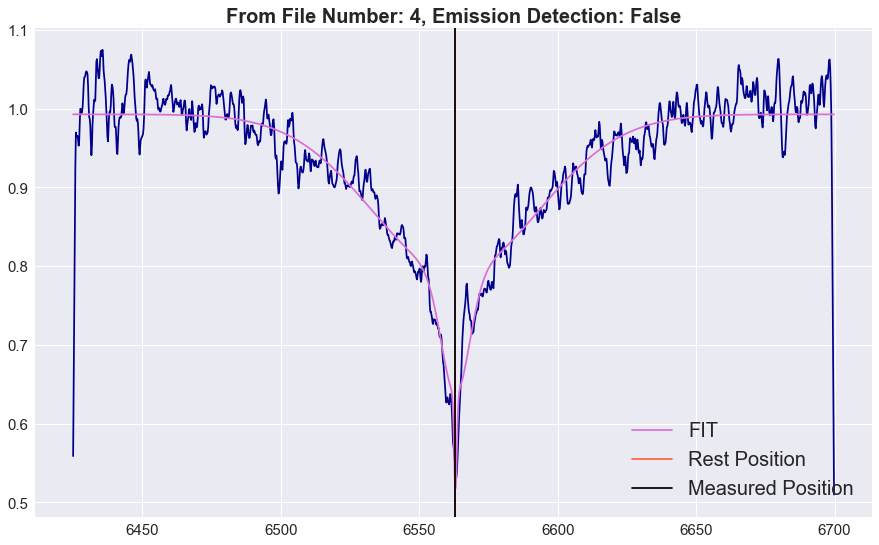

FIT INFO: (5, 5) No


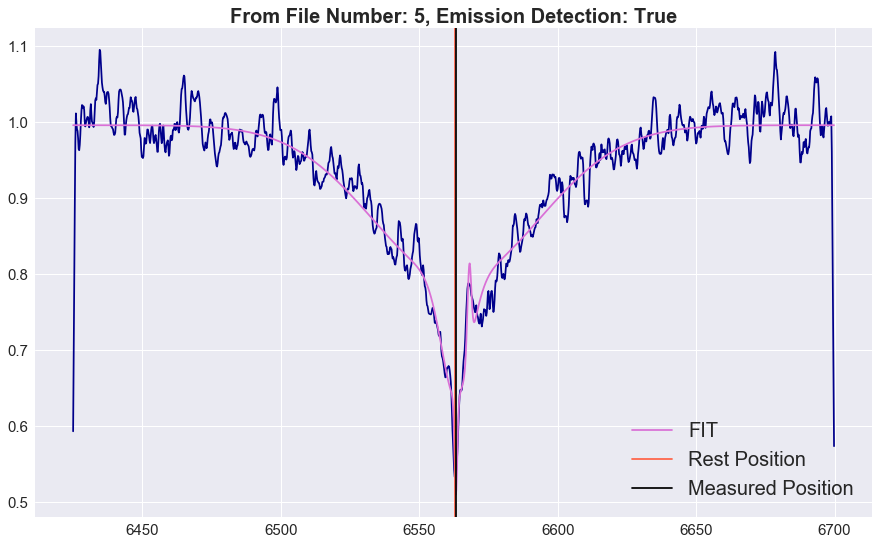

FIT INFO: (7, 7) Yes


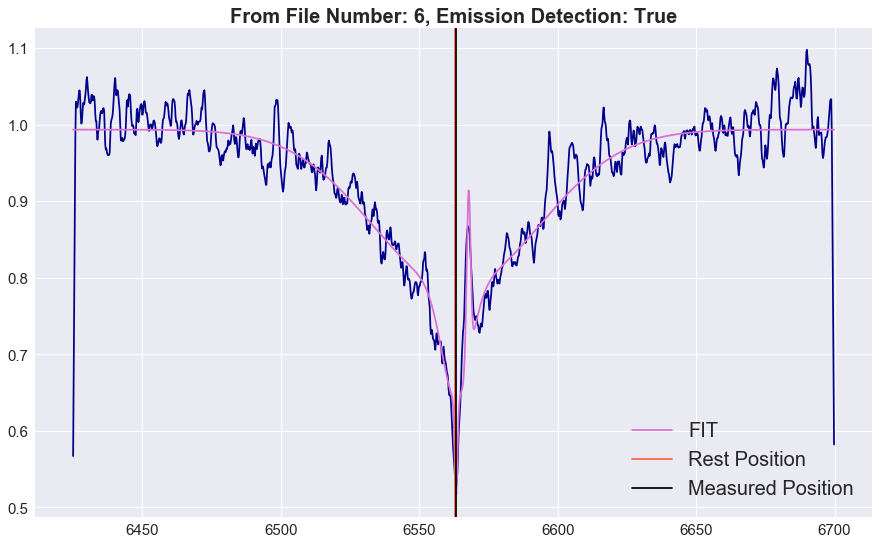

FIT INFO: (7, 7) Yes


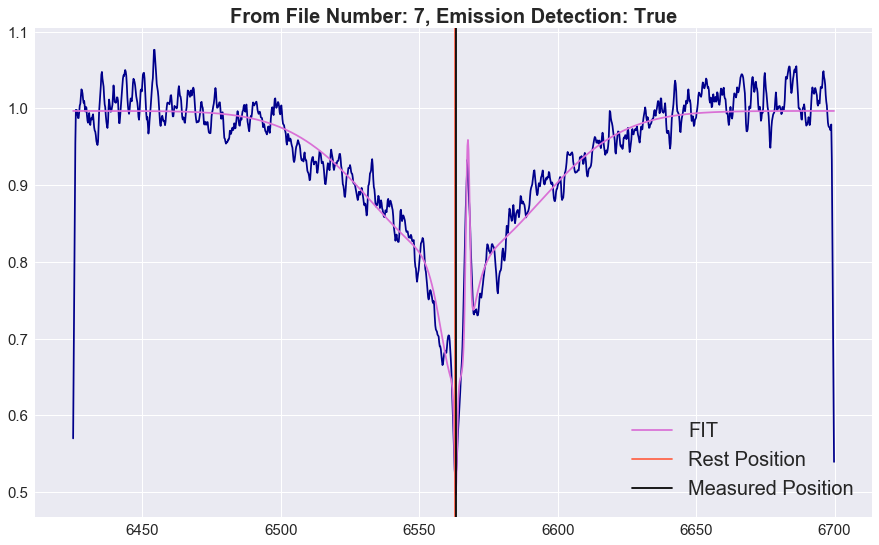

FIT INFO: (7, 7) Yes


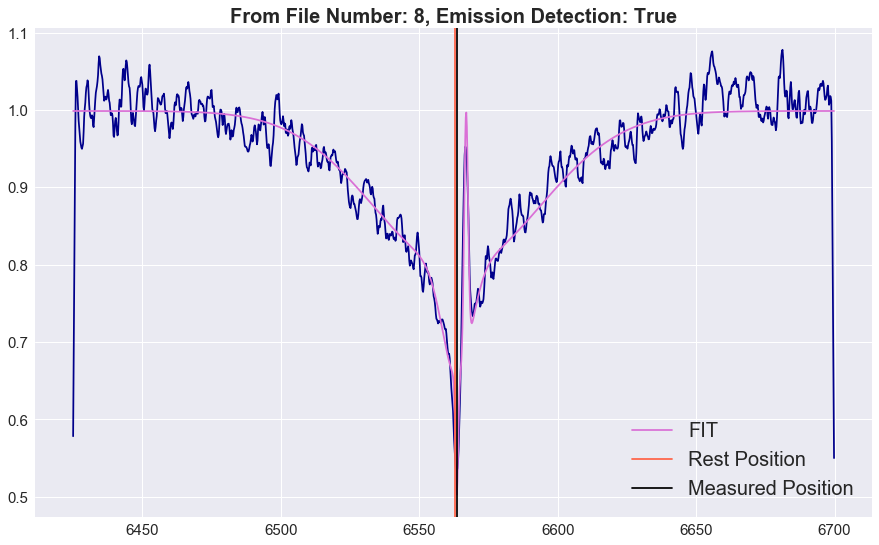

FIT INFO: (7, 7) Yes


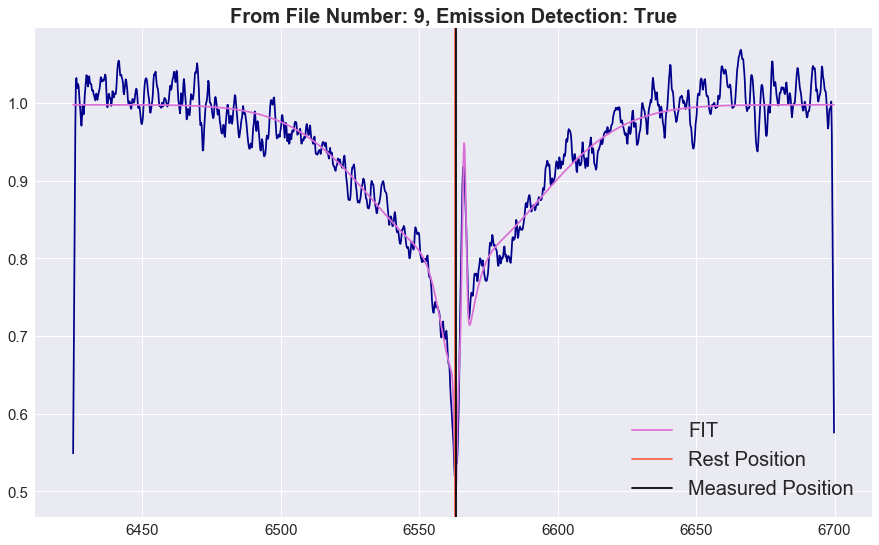

FIT INFO: (7, 7) Yes


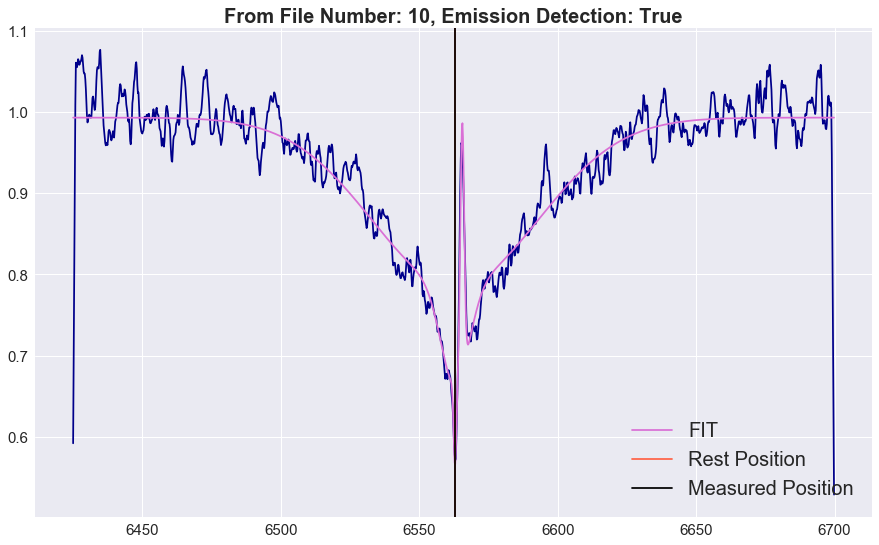

FIT INFO: (7, 7) Yes


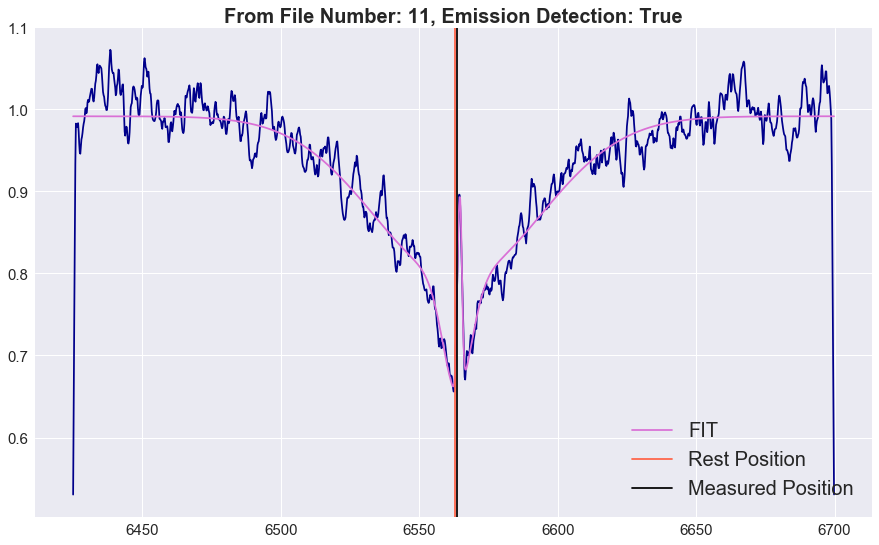

FIT INFO: (7, 7) Yes


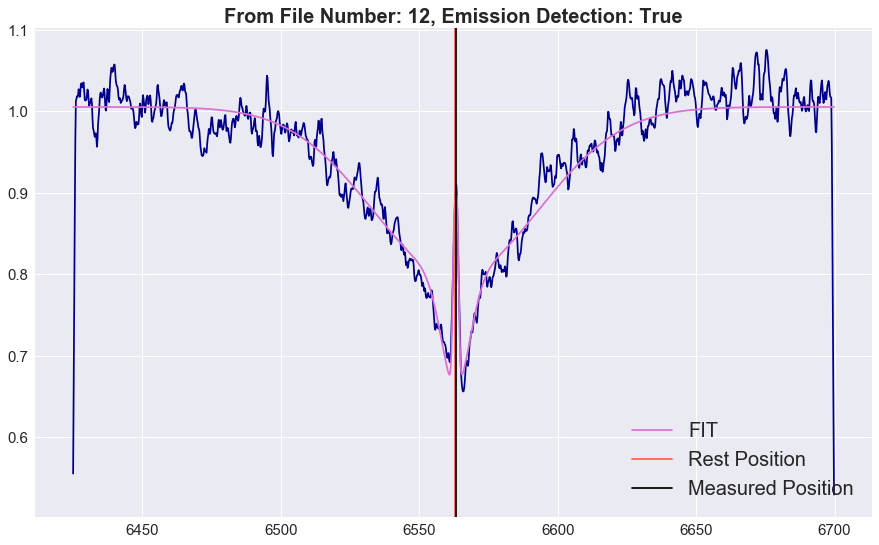

FIT INFO: (7, 7) Yes


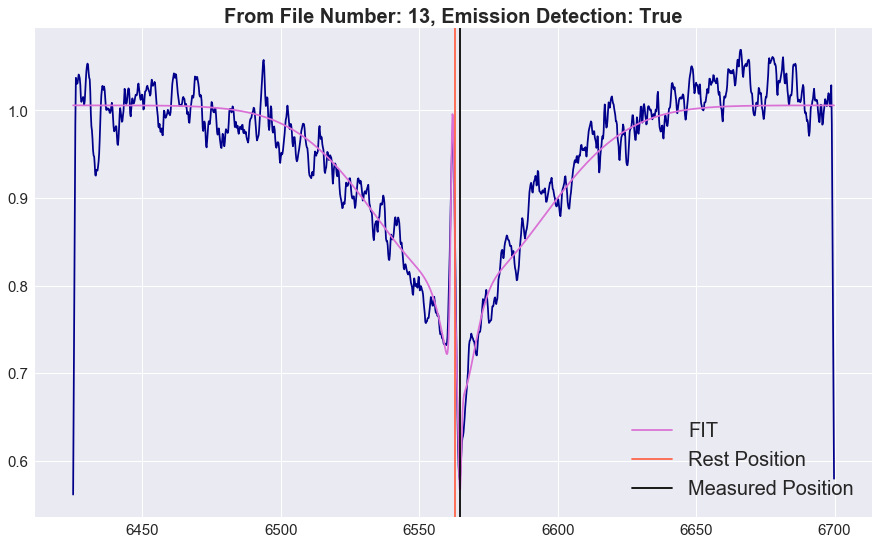

FIT INFO: (7, 7) Yes


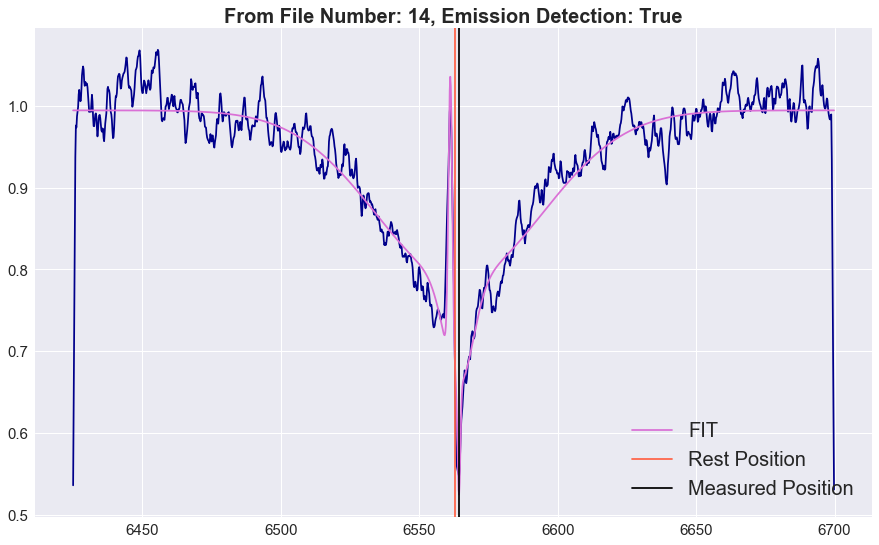

FIT INFO: (7, 7) Yes


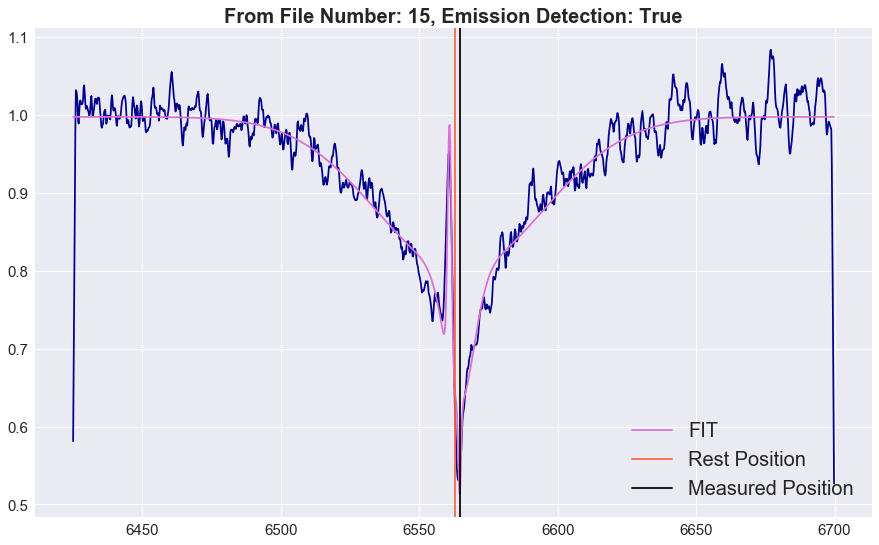

FIT INFO: (7, 7) Yes


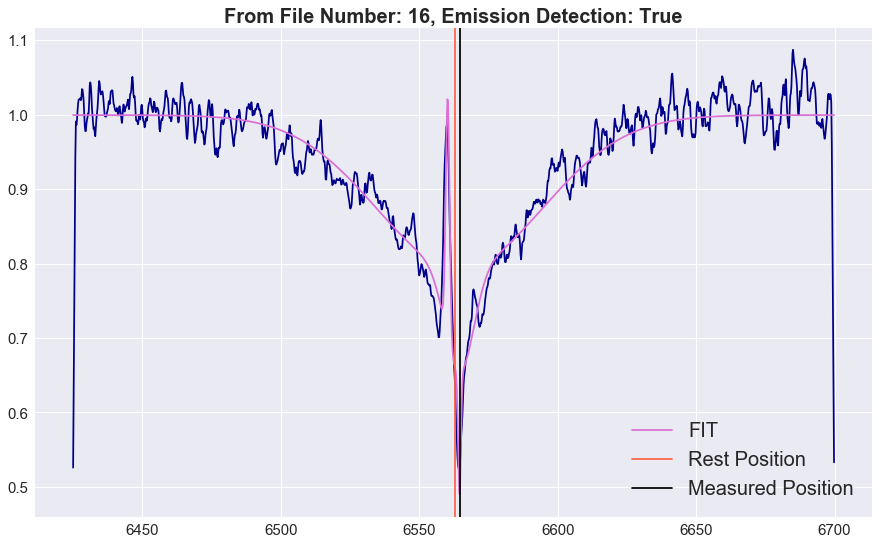

FIT INFO: (7, 7) Yes


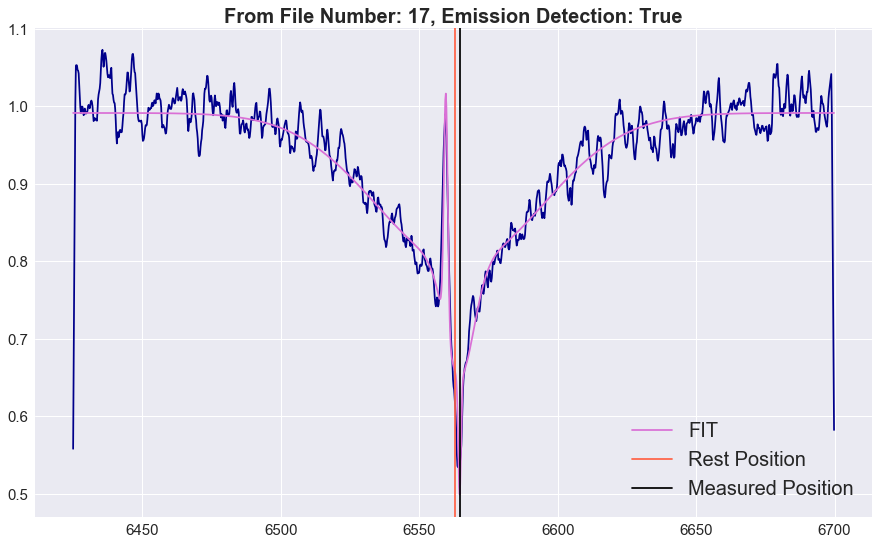

FIT INFO: (7, 7) Yes


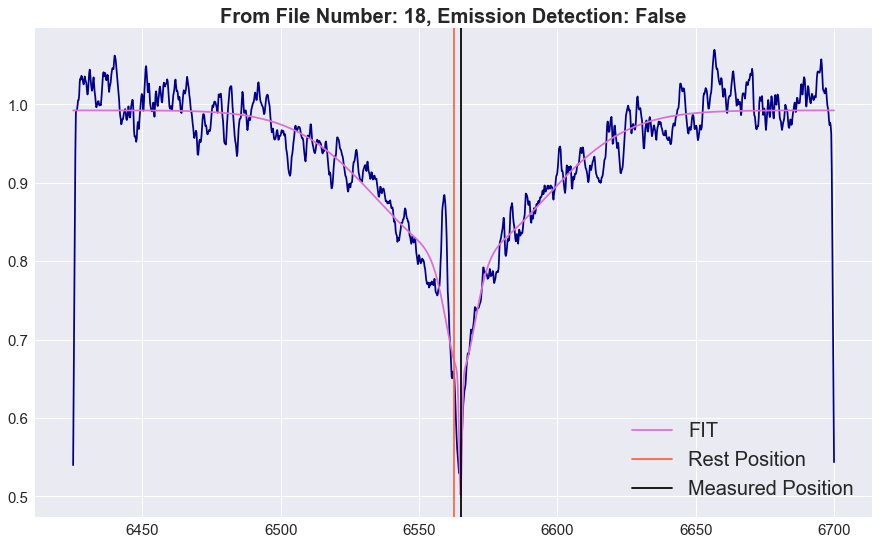

FIT INFO: (5, 5) No


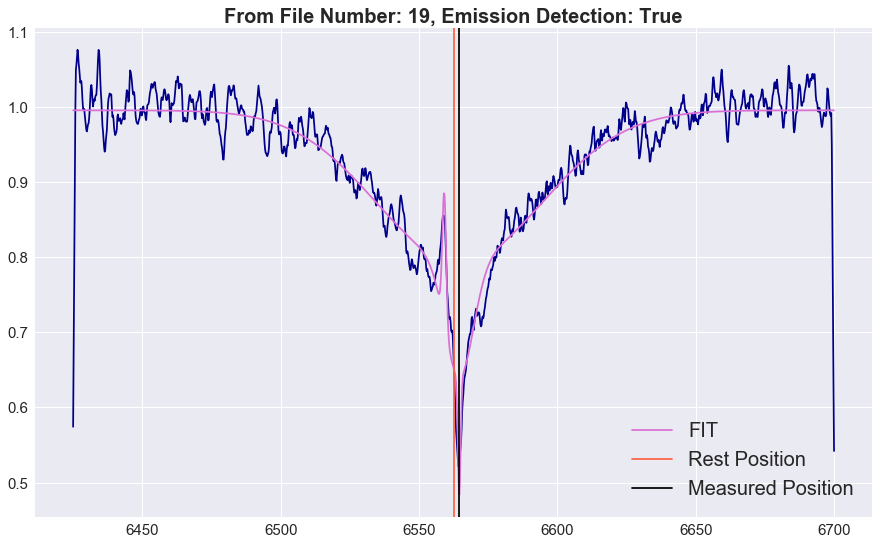

FIT INFO: (7, 7) Yes


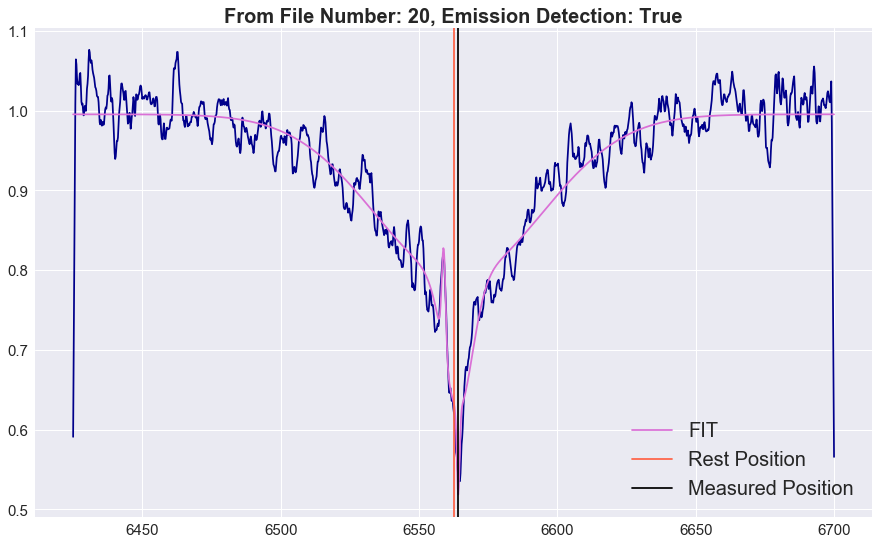

FIT INFO: (7, 7) Yes


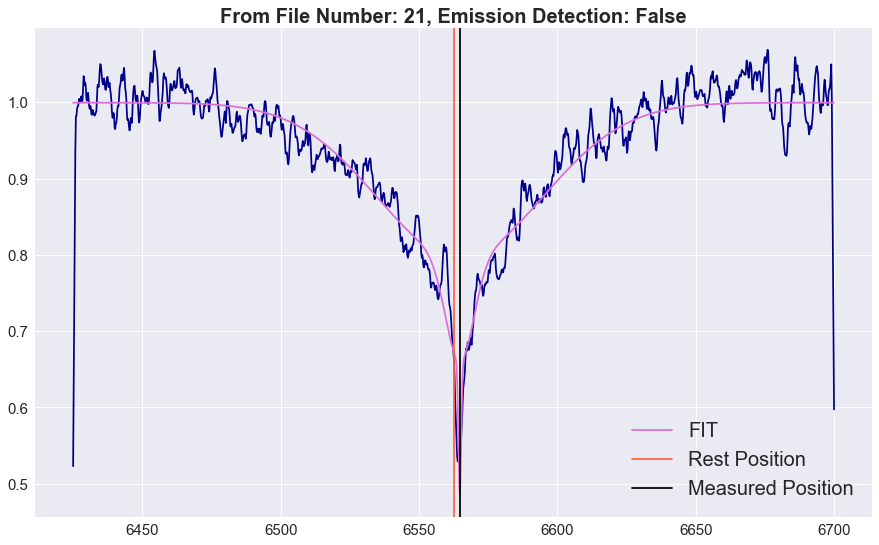

FIT INFO: (5, 5) No


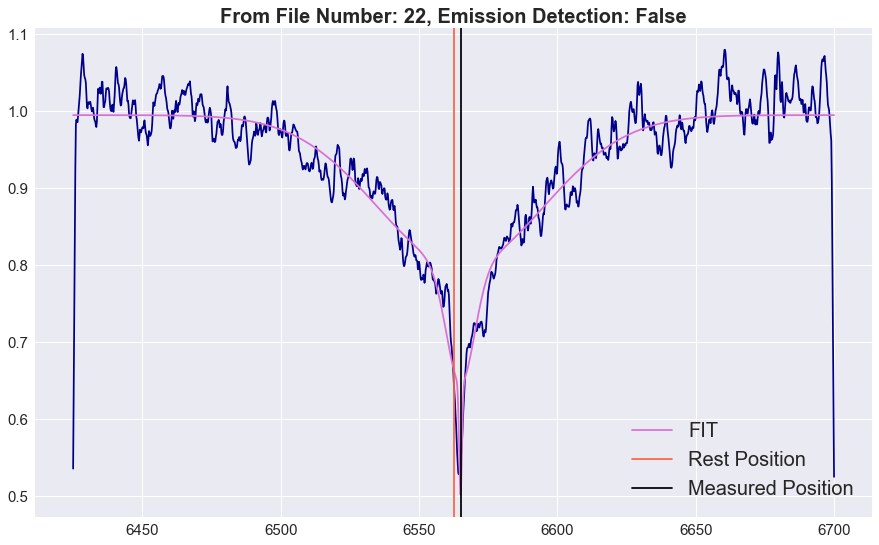

FIT INFO: (5, 5) No


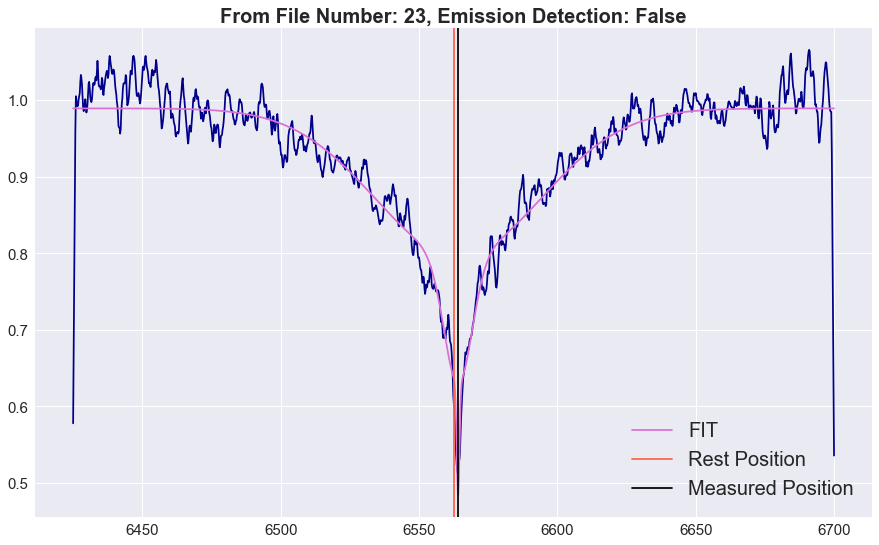

FIT INFO: (5, 5) No


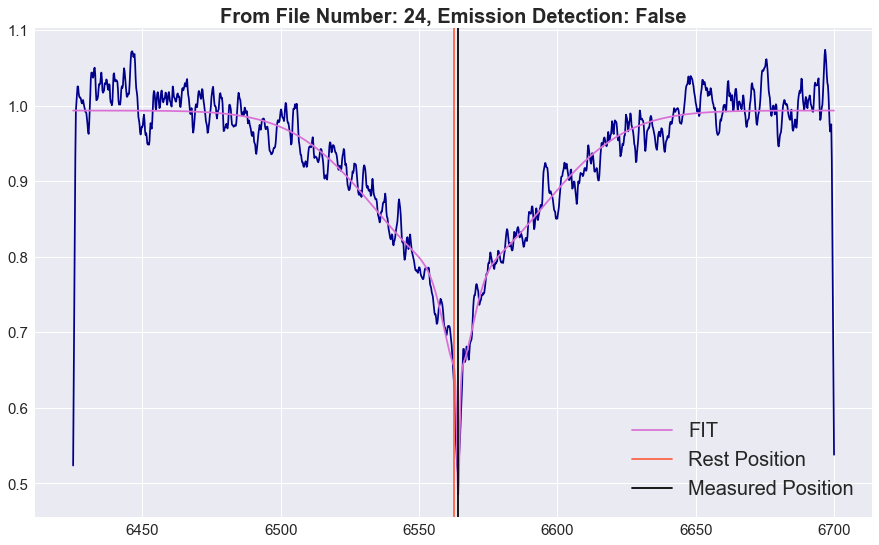

FIT INFO: (5, 5) No


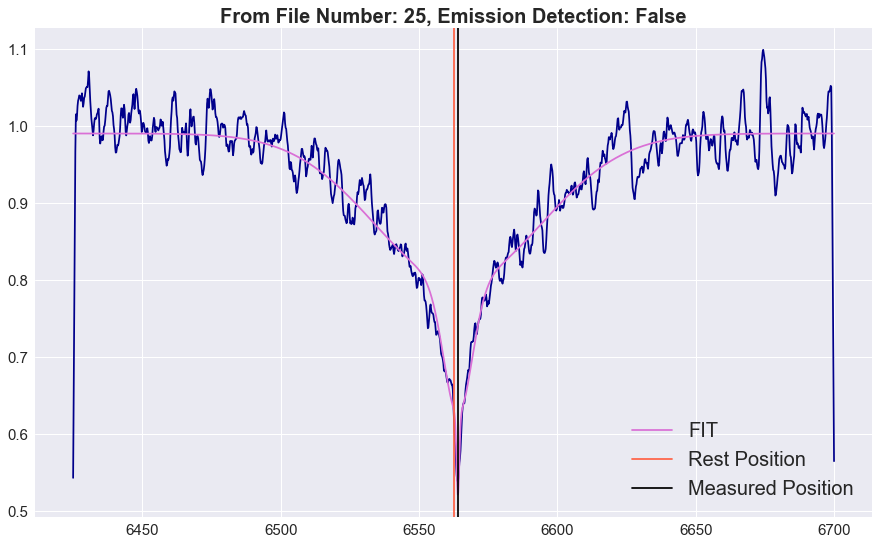

FIT INFO: (5, 5) No


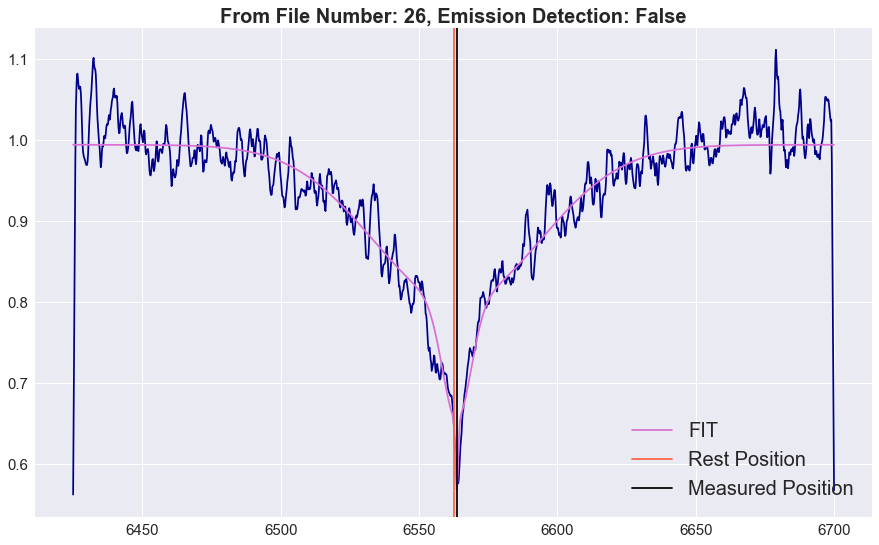

FIT INFO: (5, 5) No


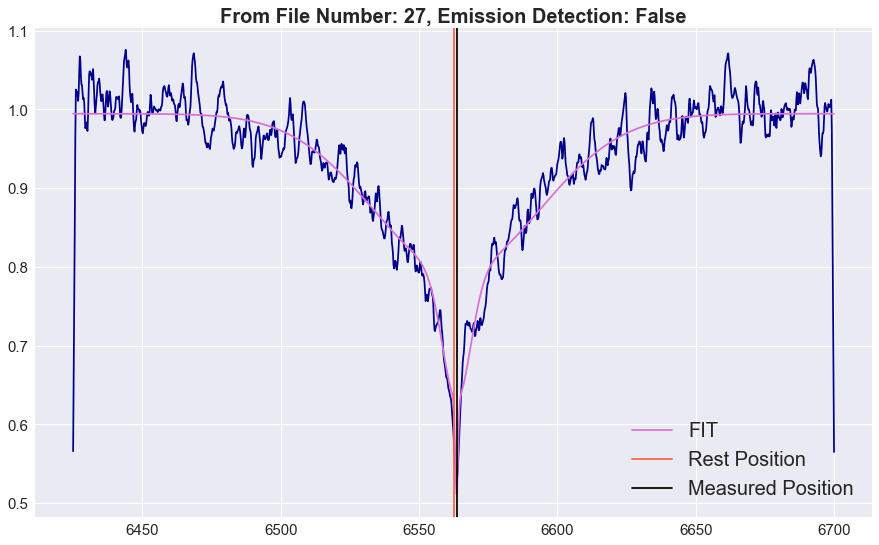

FIT INFO: (5, 5) No


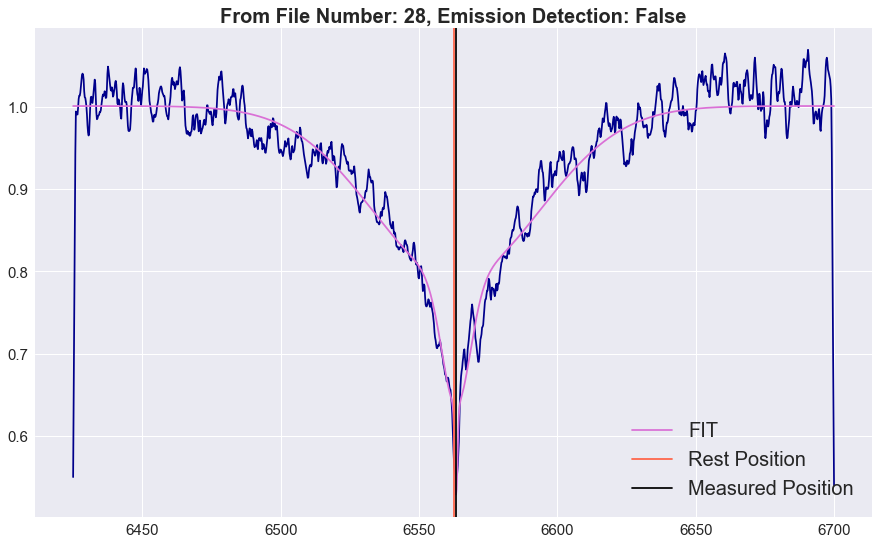

FIT INFO: (5, 5) No


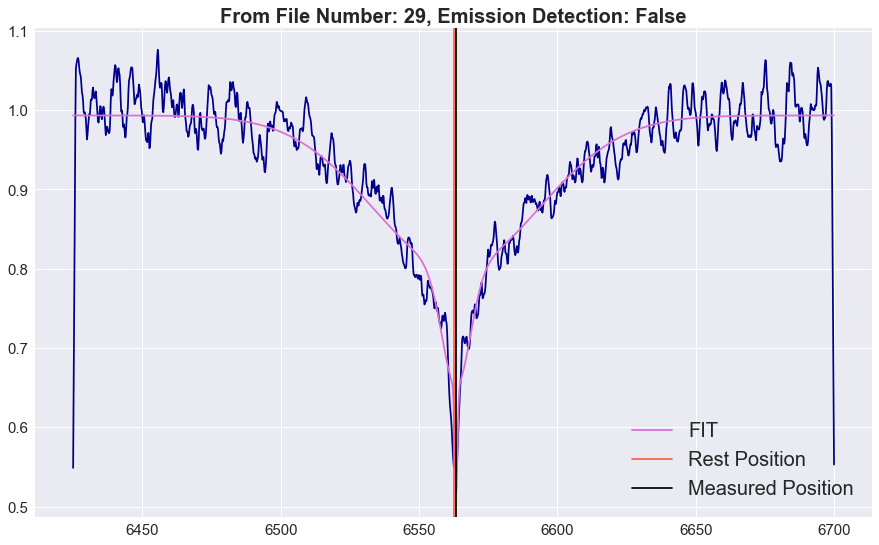

FIT INFO: (5, 5) No


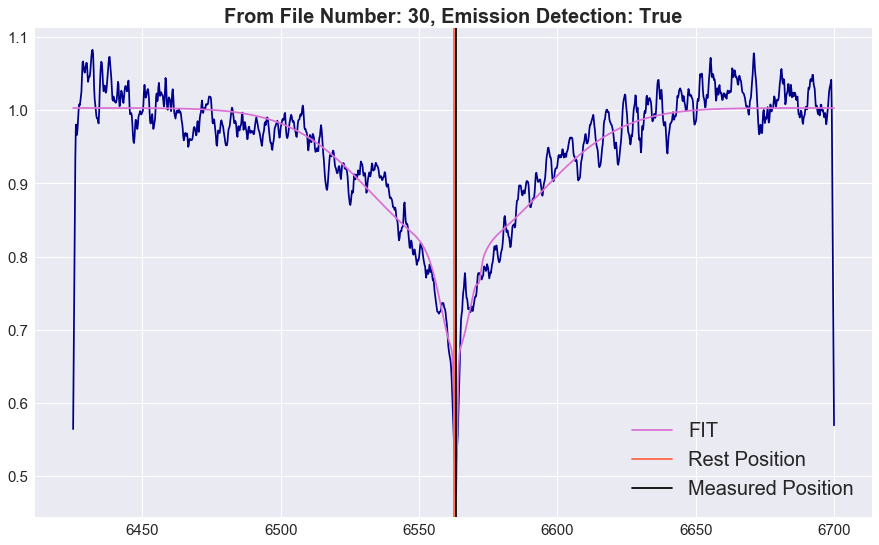

FIT INFO: (7, 7) Yes


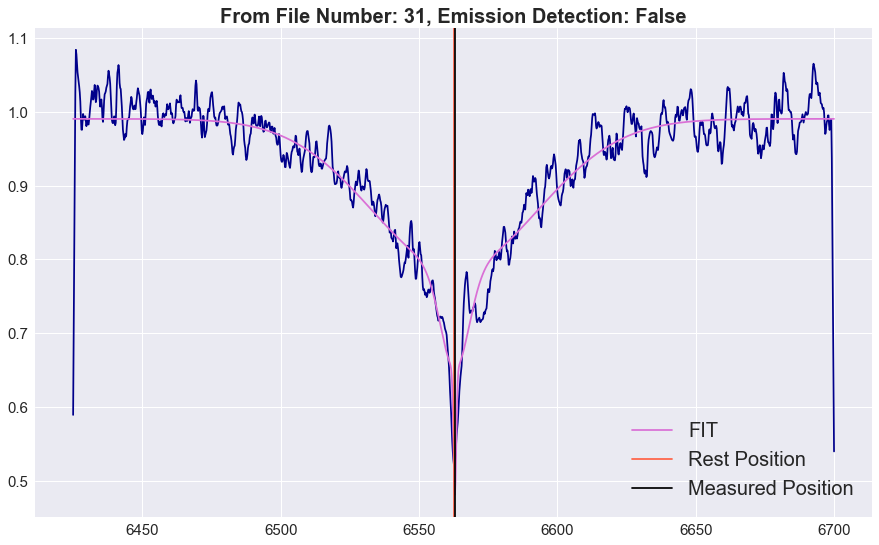

FIT INFO: (5, 5) No


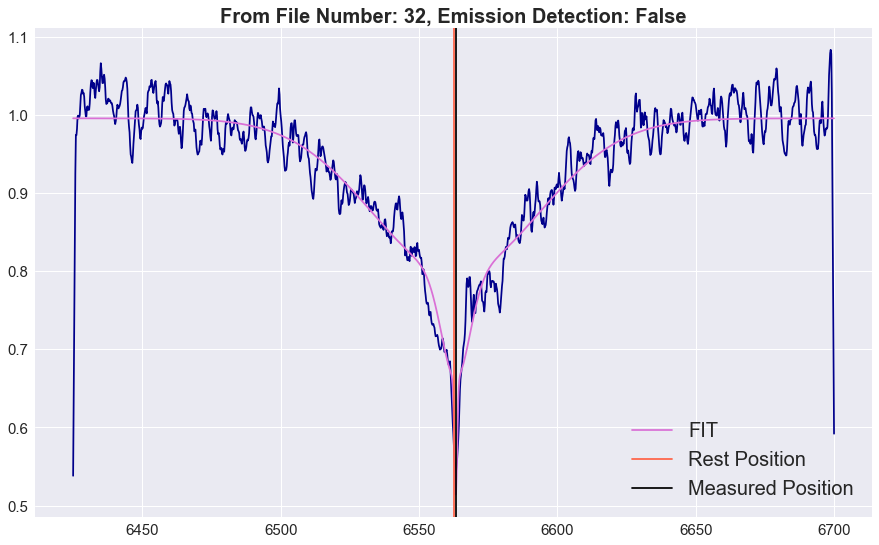

FIT INFO: (5, 5) No


File name for the table? DEFINITE_OGData_HA.csv


In [10]:
path = "/Users/linaflorez/Desktop/UT_TAURUS/WDJ114404.76+052951.77/" #note the / on the end
vispath = path + 'VIS_notell/'
sp_csv = natsort.natsorted(glob.glob(vispath+'*TAC.csv')) #makes an array containing the path to all csv files. Note the TAC as I didn't want to include the merged spectrum
sp_fits = natsort.natsorted(glob.glob(vispath+'*TAC.fits')) #makes an array containing the path to all csv files. Note the TAC as I didn't want to include the merged spectrum
#wavelength_range = (6300, 6800)
wavelength_range = (6425, 6700)

df = pd.read_csv("/Users/linaflorez/Desktop/UT_TAURUS/CSV_FILES/OriginalData.csv")
detections = df['Detections']

#CSV FILE: OGData_HA.csv

fitting_absorption_lines(wavelength_range, sp_csv, sp_fits, detections)

### OLD DATA

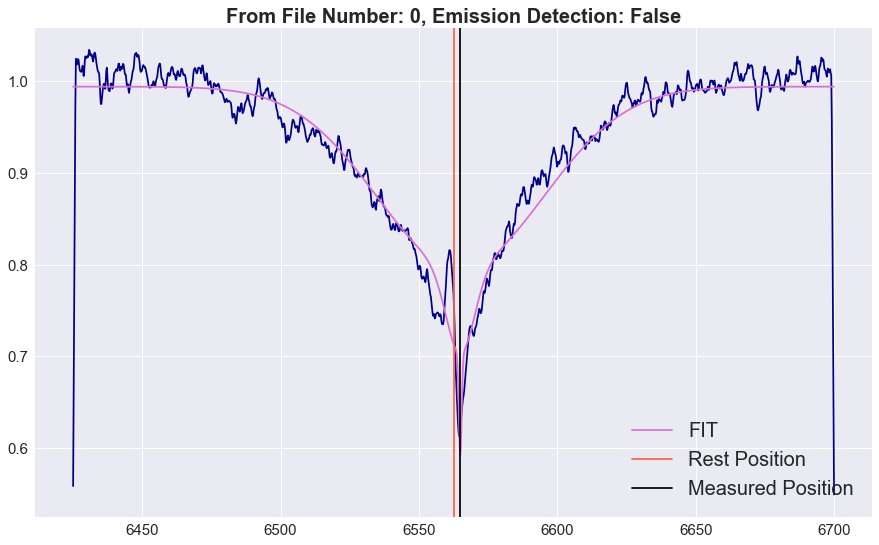

FIT INFO: (5, 5) No


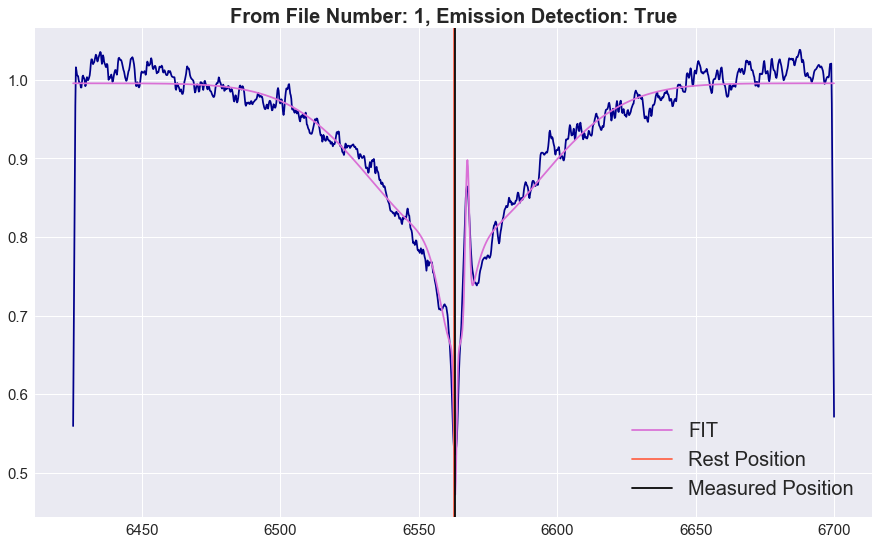

FIT INFO: (7, 7) Yes


File name for the table? DEFINITE_NEWOLD_HA.csv


In [11]:
path = "/Users/linaflorez/Desktop/UT_TAURUS/" #note the / on the end
#print(os.listdir(path))
vispath = path + 'SDSSJ1144_old2/'
sp_csv = natsort.natsorted(glob.glob(vispath+'*TAC.csv')) #makes an array containing the path to all csv files. Note the TAC as I didn't want to include the merged spectrum
sp_fits = natsort.natsorted(glob.glob(vispath+'*TAC.fits')) #makes an array containing the path to all csv files. Note the TAC as I didn't want to include the merged spectrum
#wavelength_range = (6300, 6800)
wavelength_range = (6425, 6700)

df = pd.read_csv("/Users/linaflorez/Desktop/UT_TAURUS/CSV_FILES/NEW_OLD.csv")
detections = df['Detections']

#CSV FILE: NEWOLD_HA.csv
fitting_absorption_lines(wavelength_range, sp_csv, sp_fits, detections)

### Making the LS and Folded Velocity Plot

In [577]:
def making_LS_and_fv(list_of_csv):
    ###############################################################
    ### GETTING DATA
    ###############################################################     
    calcium_df = pd.concat((pd.read_csv(list_of_csv[0]), pd.read_csv(list_of_csv[1])), axis = 0)
    halpha_df = pd.concat((pd.read_csv(list_of_csv[2]), pd.read_csv(list_of_csv[3])), axis = 0)
    
    ###############################################################
    ### SETTING UP PLOT
    ############################################################### 
    plt.style.use("seaborn")
    plt.figure(figsize=(8, 8), frameon = True, edgecolor = "black")
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(20,10))

    ###############################################################
    ### MAKING THE LOMB-SCARGLE
    ############################################################### 
    decision = input("Period From Calcium Lines or H\u03B1 Line? ")
    if decision == "Calcium Lines":
        data = calcium_df.loc[calcium_df['Detections'] == 'Yes']
        t, y, dy = data["MJD"], data["Weighted Mean"], data["Weighted Error"]
        frequency, power = LS(t, y, dy, normalization= "model").autopower(minimum_frequency = 4, maximum_frequency = 12)
        period = (1/frequency)
        period_value = period[np.argmax(power)]*24
        ax1.text(3, 2000,"Period: %.3f hours" % (period_value), size = 15)
        
    else:
        data = halpha_df.loc[halpha_df["Detections (based on previous dv measurements)"] == 'Yes']
        t, dy = data["MJD"], data["Fit Error"]
        y = data["Emission -- DV (km/s)"]
#         y = data["Absorption -- DV (km/s)"]
        frequency, power = LS(t, y, dy, normalization= "model").autopower(minimum_frequency = 4, maximum_frequency = 12)
        period = (1/frequency)
        period_value = period[np.argmax(power)]*24
        ax1.text(3, 15,"Period: %.3f hours" % (period_value), size = 15)


    ax1.plot(period * 24, power, color = "darkblue", label = "Lomb Scargle")
    ax1.set_xlabel("Period (hours)", weight = "bold", size = 15)
    ax1.set_ylabel("Lomb-Scargle Power", weight = "bold", size = 15)
    ax1.set_xlim(2,6)
    ax1.tick_params("both", labelsize = 15)
    ######################################################################################################## 
    
    ###############################################################
    ### MAKING THE TIME V VEL PLOT
    ############################################################### 
    time = ((halpha_df["MJD"].values * u.day).to(u.hour)).value
    dv_a, dv_e = halpha_df["Absorption -- DV (km/s)"], halpha_df["Emission -- DV (km/s)"]
    
    ax2.scatter(time, dv_a, color = "darkblue", s = 50, label = "Absorption")
    ax2.scatter(time, dv_e, color = "darkcyan", s = 50, label = "Emission")
    ax2.set_xlabel("Time (Hour)", weight = "bold", size = 20)
    ax2.set_ylabel("Velocity (km/s)", weight = "bold", size = 20)
    ax2.set_xlim(1.406447e6,1.406457e6)
    ax2.legend(loc = "best", prop = {"size":15})
    ax2.tick_params("both", labelsize = 15)

    ######################################################################################################## 
    
    ###############################################################
    ### MAKING FOLDED VELOCITY PLOT
    ############################################################### 
    #EMISSION DETECTED
    ca_emission_detected = calcium_df.loc[calcium_df['Detections'] == "Yes"]
    ca_emission_filepath = ca_emission_detected["File Path"]
    ca_emission_detected_x = ((ca_emission_detected["MJD"].values)/(1/(frequency[np.argmax(power)]))) %1
    ca_emission_detected_x = np.append(ca_emission_detected_x,ca_emission_detected_x+1)
    ca_emission_detected_y = ca_emission_detected["Weighted Mean"]
    ca_emission_detected_y = np.tile(ca_emission_detected_y,2)
    
    ha_emission_detected = halpha_df.loc[halpha_df["Detections (based on previous dv measurements)"] == "Yes"]
    ha_emission_filepath = ha_emission_detected["File Path"]
    ha_emission_detected_x = ((ha_emission_detected["MJD"].values)/(1/(frequency[np.argmax(power)]))) %1
    ha_emission_detected_x = np.append(ha_emission_detected_x,ha_emission_detected_x+1)
    ha_emission_detected_y = ha_emission_detected["Emission -- DV (km/s)"]
    ha_emission_detected_y = np.tile(ha_emission_detected_y,2)
    
    ha_absorption_detected = halpha_df.loc[halpha_df["Detections (based on previous dv measurements)"] == "Yes"]
    ha_absorption_filepath = ha_absorption_detected["File Path"]
    ha_absorption_detected_x = ((ha_absorption_detected["MJD"].values)/(1/(frequency[np.argmax(power)]))) %1
    ha_absorption_detected_x = np.append(ha_absorption_detected_x,ha_absorption_detected_x+1)
    ha_absorption_detected_y = ha_absorption_detected["Absorption -- DV (km/s)"]
    ha_absorption_detected_y = np.tile(ha_absorption_detected_y,2)
    
    ###############################################################
    #NO EMISSION DETECTED
    ca_no_emission_detected = calcium_df.loc[calcium_df['Detections'] == "No"]
    ca_no_emission_filepath = ca_no_emission_detected["File Path"]
    ca_no_emission_detected_x = ((ca_no_emission_detected["MJD"].values)/(1/(frequency[np.argmax(power)]))) %1
    ca_no_emission_detected_x = np.append(ca_no_emission_detected_x,ca_no_emission_detected_x+1)
    ca_no_emission_detected_y = ca_no_emission_detected["Weighted Mean"]
    ca_no_emission_detected_y = np.tile(ca_no_emission_detected_y,2)
    
    ha_no_emission_detected = halpha_df.loc[halpha_df["Detections (based on previous dv measurements)"] == "No"]
    ha_no_emission_filepath = ha_no_emission_detected["File Path"]
    ha_no_emission_detected_x = ((ha_no_emission_detected["MJD"].values)/(1/(frequency[np.argmax(power)]))) %1
    ha_no_emission_detected_x = np.append(ha_no_emission_detected_x,ha_no_emission_detected_x+1)
    ha_no_emission_detected_y = ha_no_emission_detected["Emission -- DV (km/s)"]
    ha_no_emission_detected_y = np.tile(ha_no_emission_detected_y,2)
    
    ha_no_absorption_detected = halpha_df.loc[halpha_df["Detections (based on previous dv measurements)"] == "No"]
    ha_no_absorption_filepath = ha_no_absorption_detected["File Path"]
    ha_no_absorption_detected_x = ((ha_no_absorption_detected["MJD"].values)/(1/(frequency[np.argmax(power)]))) %1
    ha_no_absorption_detected_x = np.append(ha_no_absorption_detected_x,ha_no_absorption_detected_x+1)
    ha_no_absorption_detected_y = ha_no_absorption_detected["Absorption -- DV (km/s)"]
    ha_no_absorption_detected_y = np.tile(ha_no_absorption_detected_y,2)

    ###############################################################
    #PLOTTING FOLDED VELOCITY
    ax3.scatter(ca_emission_detected_x, ca_emission_detected_y, color = "dodgerblue")
    ax3.scatter(ha_absorption_detected_x, ha_absorption_detected_y, color = "darkolivegreen")
    ax3.scatter(ha_no_absorption_detected_x, ha_no_absorption_detected_y, color = "darkolivegreen")
    ax3.tick_params("both", labelsize = 15)
    ax3.set_xlabel("Orbital Phase", weight = "bold", size = 15)
    ax3.set_ylabel("Velocity (kms$^{-1}$)", weight = "bold", size = 15)

    ######################################################################################################## 
    
    ###############################################################
    ### MAKING FOLDED VELOCITY PLOT ACROSS 3 DAYS
    ############################################################### 
    mjds = np.concatenate([np.tile(ca_emission_detected["MJD"],2), np.tile(ha_absorption_detected["MJD"],2), \
                           np.tile(ha_no_absorption_detected["MJD"],2)], axis = 0)
    xs = np.concatenate([ca_emission_detected_x, ha_absorption_detected_x, ha_no_absorption_detected_x], axis = 0)
    ys = np.concatenate([ca_emission_detected_y, ha_absorption_detected_y, ha_no_absorption_detected_y], axis = 0)
    xs = np.concatenate([ca_emission_detected_x, ha_absorption_detected_x, ha_no_absorption_detected_x], axis = 0)
    ys = np.concatenate([ca_emission_detected_y, ha_absorption_detected_y, ha_no_absorption_detected_y], axis = 0)
    t = Table([mjds, xs, ys], names=('MJD', 'PHASE', 'VELOCITY'), dtype=('f4', 'f4', 'f4'))

    day_one = []
    day_two = []
    day_three = []
    for i in range(len(mjds)):
        if math.modf(mjds[i])[1] == 58168.0:
            day_one.append(i)
        if math.modf(mjds[i])[1] == 58601.0:
            day_two.append(i)
        if math.modf(mjds[i])[1] == 58602.0:
            day_three.append(i)

    ax4.scatter(xs[day_one], ys[day_one], color = "orange", label = "Day One")
    ax4.scatter(xs[day_two], ys[day_two], color = "brown",  label = "Day Two")
    ax4.scatter(xs[day_three], ys[day_three], color = "mediumorchid", label = "Day Three")
    ax4.legend(loc = "best", prop = {"size":15})
    ax4.tick_params("both", labelsize = 15)


<Figure size 576x576 with 0 Axes>

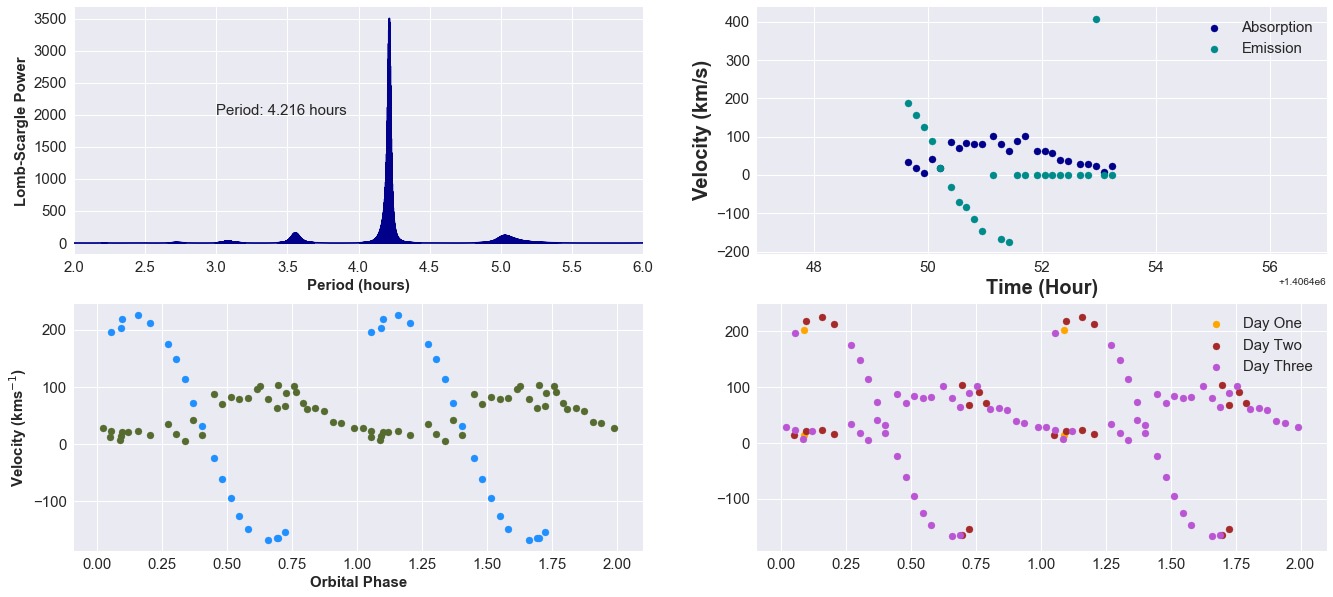

In [578]:
CA_CSV_OLD = "/Users/linaflorez/Desktop/Summer2019/CSV_FILES/NEW_OLD.csv"
CA_CSV_RECENT = "/Users/linaflorez/Desktop/Summer2019/CSV_FILES/OriginalData.csv"
HA_CSV_OLD = "/Users/linaflorez/Desktop/Summer2019/CSV_FILES/NEWOLD_HA.csv"
HA_CSV_RECENT = "/Users/linaflorez/Desktop/Summer2019/CSV_FILES/OGData_HA.csv"

list_of_data = (CA_CSV_OLD,CA_CSV_RECENT, HA_CSV_OLD, HA_CSV_RECENT)

making_LS_and_fv(list_of_data)